In [ ]:
INPUT_DIR = '../dataset/train'

## method 1

In [ ]:
import os
import cv2
import numpy as np

input_dir = INPUT_DIR           
output_dir = 'segmented_visuals'
os.makedirs(output_dir, exist_ok=True)


def merge_overlapping_boxes(boxes, overlap_thresh=0.5):
    merged = []
    boxes = sorted(boxes, key=lambda b: b[0])
    for box in boxes:
        x, y, w, h = box
        merged_flag = False
        for i, (mx, my, mw, mh) in enumerate(merged):
            if abs(x - mx) < max(w, mw) * overlap_thresh and abs(y - my) < max(h, mh) * 0.7:
                nx = min(x, mx)
                ny = min(y, my)
                nw = max(x + w, mx + mw) - nx
                nh = max(y + h, my + mh) - ny
                merged[i] = (nx, ny, nw, nh)
                merged_flag = True
                break
        if not merged_flag:
            merged.append(box)
    return merged


def split_wide_box(img, x, y, w, h, threshold=40):
    sub_img = img[y:y+h, x:x+w]
    gray = cv2.cvtColor(sub_img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    projection = np.sum(binary, axis=0)

    split_points = []
    for i in range(1, len(projection)):
        if projection[i-1] > 0 and projection[i] == 0:
            split_points.append(i)

    boxes = []
    prev = 0
    for sp in split_points + [w]:
        if sp - prev > 5:
            boxes.append((x + prev, y, sp - prev, h))
        prev = sp
    return boxes if len(boxes) > 1 else [(x, y, w, h)]


def process_image(image_path, save_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️ 无法读取图像：{image_path}")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contrast = np.std(gray)
    if contrast < 25:
        b, g, r = cv2.split(img)
        gray = cv2.max(b, cv2.max(g, r))
        gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)

    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 25, 15
    )

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(clean)

    char_boxes = []
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if area > 50 and h > 10 and w > 3:
            char_boxes.append((x, y, w, h))

    char_boxes = merge_overlapping_boxes(char_boxes)
    char_boxes = sorted(char_boxes, key=lambda b: b[0])


    final_boxes = []
    for (x, y, w, h) in char_boxes:
        if w > 40:  # 粘连字符宽度阈值
            split_boxes = split_wide_box(img, x, y, w, h)
            final_boxes.extend(split_boxes)
        else:
            final_boxes.append((x, y, w, h))


    for (x, y, w, h) in final_boxes:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    for i in range(1, len(final_boxes)):
        x_prev = final_boxes[i - 1][0]
        w_prev = final_boxes[i - 1][2]
        x_curr = final_boxes[i][0]
        split_x = (x_prev + w_prev + x_curr) // 2
        cv2.line(img, (split_x, 0), (split_x, img.shape[0]), (255, 0, 0), 2)

    cv2.imwrite(save_path, img)


for fname in sorted(os.listdir(input_dir)):
    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(input_dir, fname)
        save_path = os.path.join(output_dir, fname)
        process_image(image_path, save_path)

print(f"✅ 已处理所有图像，输出保存至 {output_dir}/")


✅ 已处理所有图像，输出保存至 segmented_visuals/


## method 2

In [4]:
import os
import cv2
import numpy as np

input_dir = INPUT_DIR  
output_dir = 'segmented_visuals'
os.makedirs(output_dir, exist_ok=True)

def merge_overlapping_boxes(boxes, iou_thresh=0.15, gap_thresh=2):
    if not boxes:
        return []

    boxes = sorted(boxes, key=lambda b: b[0])
    merged = []

    for box in boxes:
        x, y, w, h = box
        merged_flag = False

        for i, (mx, my, mw, mh) in enumerate(merged):
            ix1, iy1 = max(x, mx), max(y, my)
            ix2, iy2 = min(x + w, mx + mw), min(y + h, my + mh)
            iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
            intersection = iw * ih
            union = w * h + mw * mh - intersection
            iou = intersection / union if union > 0 else 0

            horiz_gap = max(0, max(mx, x) - min(mx + mw, x + w))
            size_ratio = min(w, mw) / max(w, mw) * min(h, mh) / max(h, mh)

            if (iou > iou_thresh or horiz_gap <= gap_thresh) and size_ratio > 0.5:
                nx = min(x, mx)
                ny = min(y, my)
                nw = max(x + w, mx + mw) - nx
                nh = max(y + h, my + mh) - ny
                merged[i] = (nx, ny, nw, nh)
                merged_flag = True
                break

        if not merged_flag:
            merged.append(box)

    return merged

def split_wide_box(img, x, y, w, h, threshold=40):
    sub_img = img[y:y+h, x:x+w]
    gray = cv2.cvtColor(sub_img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    projection = np.sum(binary, axis=0)

    split_points = []
    for i in range(1, len(projection)):
        if projection[i-1] > 0 and projection[i] == 0:
            split_points.append(i)

    boxes = []
    prev = 0
    for sp in split_points + [w]:
        if sp - prev > 5:
            boxes.append((x + prev, y, sp - prev, h))
        prev = sp
    return boxes if len(boxes) > 1 else [(x, y, w, h)]

def process_image(image_path, save_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️ 无法读取图像：{image_path}")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    contrast = np.std(gray)
    if contrast < 25:
        b, g, r = cv2.split(img)
        gray = cv2.max(b, cv2.max(g, r))
        gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)

    gray = cv2.equalizeHist(gray)
    gray = np.power(gray / 255.0, 0.8)
    gray = np.uint8(gray * 255)

    thresh1 = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 15
    )
    _, thresh2 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    thresh = cv2.bitwise_or(thresh1, thresh2)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(clean)

    char_boxes = []
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if 40 < area < 2000 and 10 < h < img.shape[0] * 0.9 and w > 3:
            char_boxes.append((x, y, w, h))

    char_boxes = merge_overlapping_boxes(char_boxes)
    char_boxes = sorted(char_boxes, key=lambda b: b[0])

    final_boxes = []
    for (x, y, w, h) in char_boxes:
        if w > 40:
            split_boxes = split_wide_box(img, x, y, w, h)
            final_boxes.extend(split_boxes)
        else:
            final_boxes.append((x, y, w, h))

    # 可视化字符框
    for (x, y, w, h) in final_boxes:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    for i in range(1, len(final_boxes)):
        x_prev = final_boxes[i - 1][0]
        w_prev = final_boxes[i - 1][2]
        x_curr = final_boxes[i][0]
        split_x = (x_prev + w_prev + x_curr) // 2
        cv2.line(img, (split_x, 0), (split_x, img.shape[0]), (255, 0, 0), 2)

    # 保存图像
    cv2.imwrite(save_path, img)

    # 输出字符框位置
    print(f"📦 {os.path.basename(image_path)} 字符框位置:")
    char_positions = []
    for i, (x, y, w, h) in enumerate(final_boxes):
        print(f"  字符 {i+1}: x={x}, y={y}, w={w}, h={h}")
        char_positions.append(f"{x},{y},{w},{h}")

    # 保存坐标到 txt 文件
    coord_filename = os.path.splitext(os.path.basename(image_path))[0] + '.txt'
    coord_path = os.path.join(output_dir, coord_filename)
    with open(coord_path, 'w') as f:
        f.write('\n'.join(char_positions))

# 批量处理所有图像
for fname in sorted(os.listdir(input_dir)):
    if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(input_dir, fname)
        save_path = os.path.join(output_dir, fname)
        process_image(image_path, save_path)

print(f"\n✅ 已处理所有图像，图像和坐标保存至 {output_dir}/")


📦 0024miih-0.png 字符框位置:
  字符 1: x=93, y=30, w=23, h=32
  字符 2: x=154, y=30, w=26, h=34
  字符 3: x=212, y=30, w=26, h=32
  字符 4: x=275, y=30, w=24, h=34
  字符 5: x=333, y=29, w=25, h=32
  字符 6: x=395, y=30, w=11, h=30
  字符 7: x=439, y=30, w=7, h=30
  字符 8: x=485, y=30, w=30, h=35
📦 002k-0.png 字符框位置:
  字符 1: x=66, y=31, w=18, h=23
  字符 2: x=96, y=31, w=18, h=23
  字符 3: x=125, y=31, w=19, h=23
  字符 4: x=157, y=31, w=17, h=23
📦 006aguv-0.png 字符框位置:
  字符 1: x=145, y=27, w=13, h=28
  字符 2: x=209, y=27, w=13, h=28
  字符 3: x=273, y=27, w=13, h=28
  字符 4: x=336, y=27, w=15, h=28
  字符 5: x=403, y=27, w=13, h=28
  字符 6: x=465, y=27, w=17, h=28
  字符 7: x=531, y=27, w=17, h=28
📦 00fh-0.png 字符框位置:
📦 00hai-0.png 字符框位置:
  字符 1: x=103, y=29, w=23, h=28
  字符 2: x=155, y=29, w=23, h=28
  字符 3: x=207, y=29, w=25, h=28
  字符 4: x=260, y=29, w=30, h=28
  字符 5: x=319, y=29, w=7, h=28
📦 00hgi3n7-0.png 字符框位置:
  字符 1: x=99, y=28, w=16, h=34
  字符 2: x=132, y=28, w=16, h=34
  字符 3: x=165, y=23, w=16, h=39
  字符 4: x=

## 验证 Final Dataset 标签数据 (add by Ruiqi)

开始验证 Final Dataset 标签数据（前10张图像）

[1/10] 处理: 0024miih-0.png


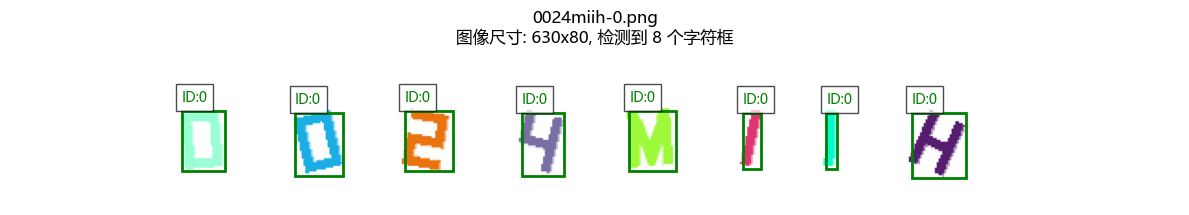


[2/10] 处理: 002k-0.png


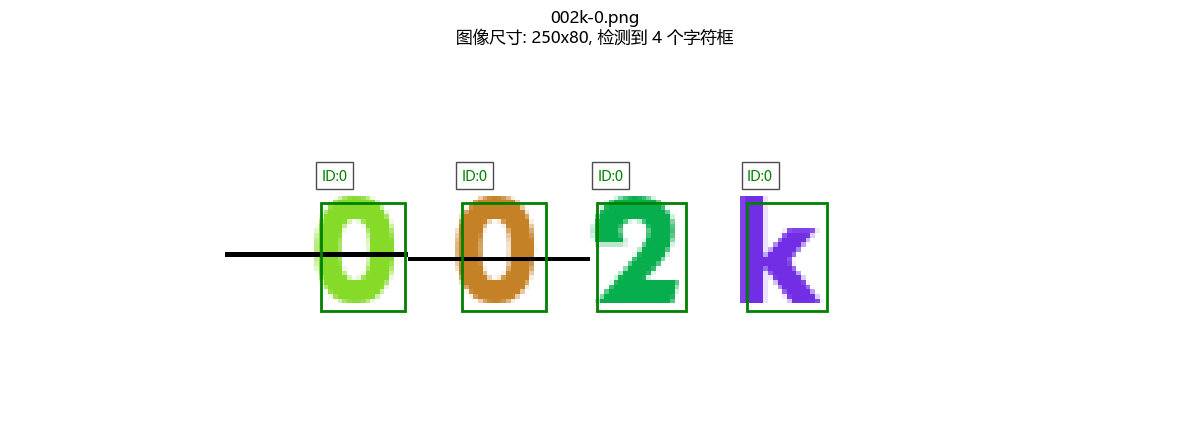


[3/10] 处理: 006aguv-0.png


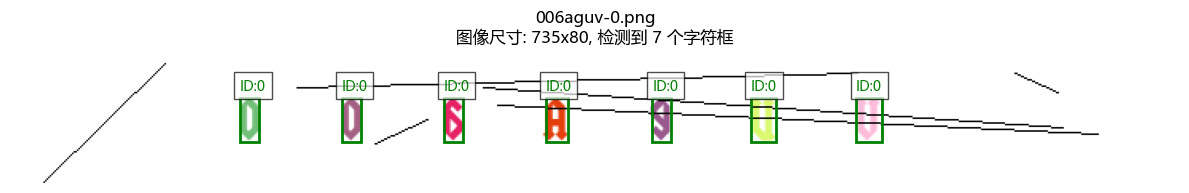


[4/10] 处理: 00fh-0_png.rf.aa5e49856c44f6bafe7aaeb423573a56.jpg


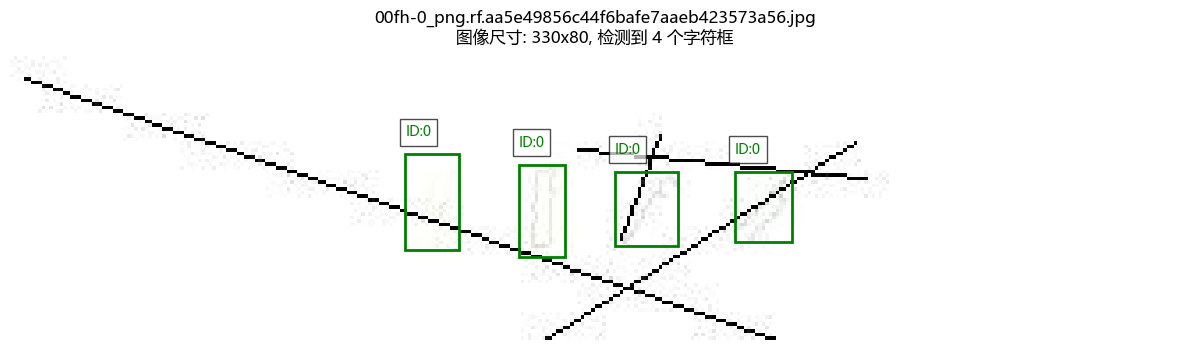


[5/10] 处理: 00hai-0.png


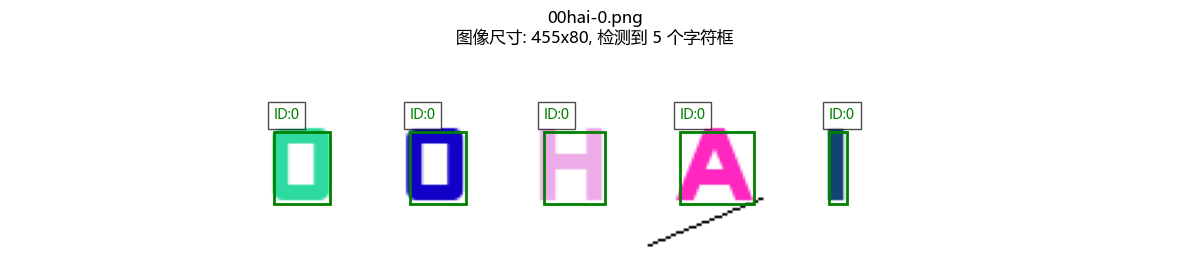


[6/10] 处理: 00hgi3n7-0.png


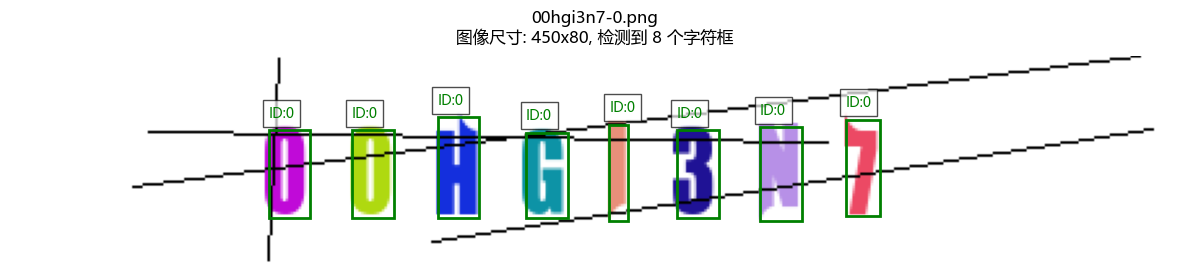


[7/10] 处理: 00o47-0.png


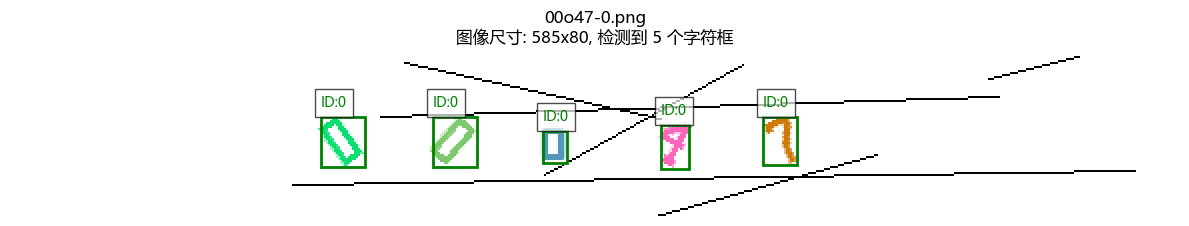


[8/10] 处理: 00wi5-0.png


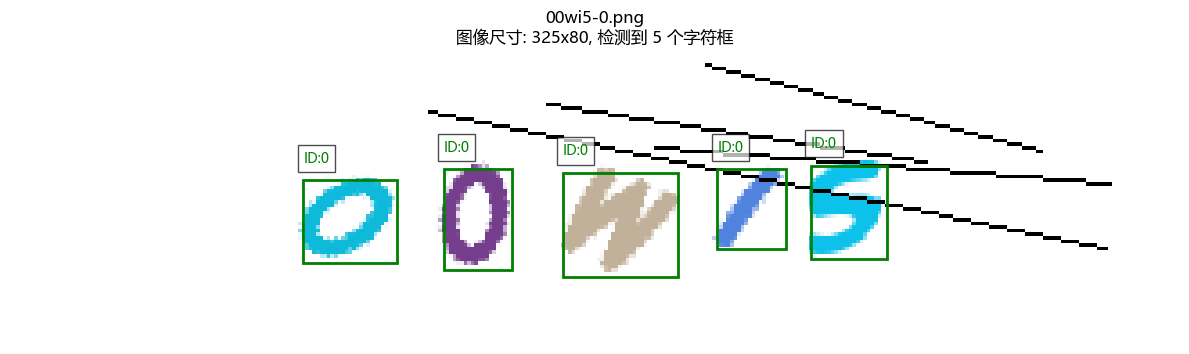


[9/10] 处理: 010b-0.png


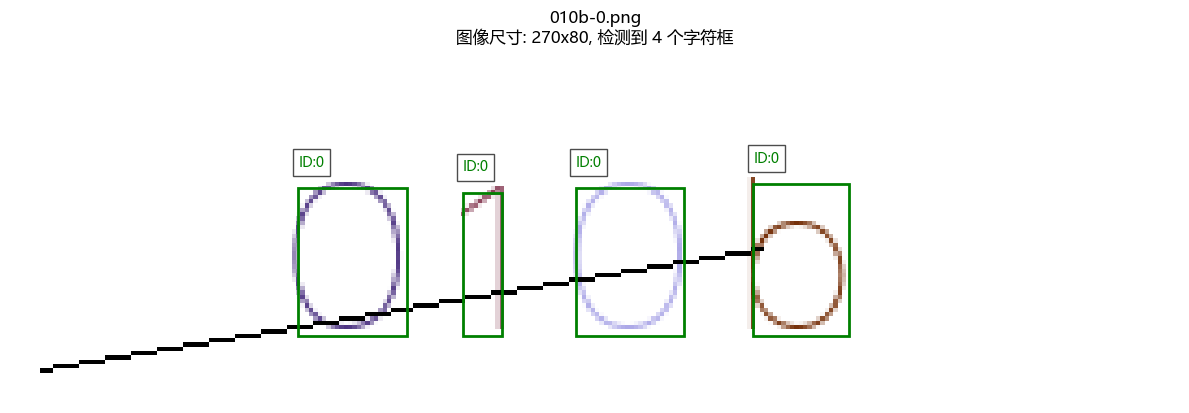


[10/10] 处理: 010ud-0.png


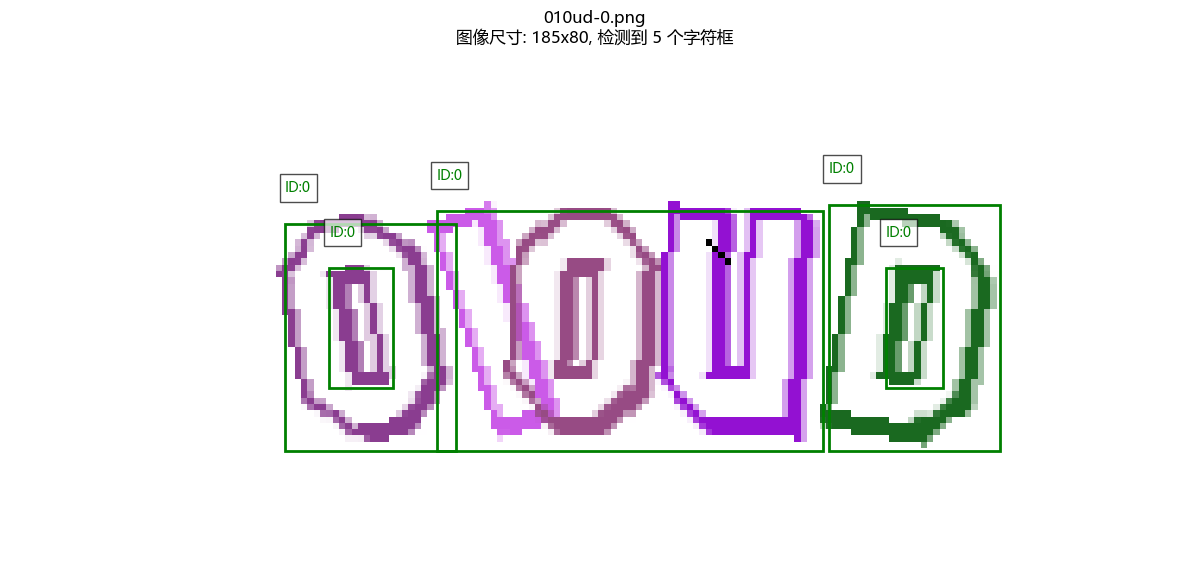


✅ 完成！成功可视化 10/10 张图像


In [17]:
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 定义数据路径
final_dataset_dir = 'final_dataset/images'
label_dir = 'final_dataset/labels'

def visualize_yolo_labels(image_path, label_path, show_filename=True):
    """
    读取图像和YOLO格式标签，并可视化分割框
    YOLO格式: <class> <x_center> <y_center> <width> <height> (归一化坐标)
    """
    # 读取图像
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️ 无法读取图像：{image_path}")
        return False
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width = img.shape[:2]
    
    # 读取标签文件
    if not os.path.exists(label_path):
        print(f"⚠️ 标签文件不存在：{label_path}")
        return False
    
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    # 创建图像显示
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    
    # 解析并绘制每个分割框
    box_count = 0
    for line in lines:
        values = line.strip().split()
        if len(values) == 5:  # YOLO 格式：class x_center y_center width height
            class_id, x_center, y_center, width, height = values
            
            # 转换为浮点数（YOLO格式是归一化的）
            x_center = float(x_center)
            y_center = float(y_center)
            width = float(width)
            height = float(height)
            
            # 转换为像素坐标
            x = int((x_center - width / 2) * img_width)
            y = int((y_center - height / 2) * img_height)
            w = int(width * img_width)
            h = int(height * img_height)
            
            # 绘制矩形框
            rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)
            
            # 在框上方显示类别ID
            ax.text(x, y - 5, f'ID:{class_id}', color='green', fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.7))
            
            box_count += 1
    
    # 显示文件名和信息
    if show_filename:
        filename = os.path.basename(image_path)
        title = f'{filename}\n图像尺寸: {img_width}x{img_height}, 检测到 {box_count} 个字符框'
        ax.set_title(title, fontsize=12, pad=10)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return True

# 处理前10张图像
print("=" * 60)
print("开始验证 Final Dataset 标签数据（前10张图像）")
print("=" * 60)

count = 0
processed = 0

# 获取所有图像文件
image_files = sorted([f for f in os.listdir(final_dataset_dir) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

for fname in image_files:
    if count >= 10:
        break
    
    image_path = os.path.join(final_dataset_dir, fname)
    label_path = os.path.join(label_dir, os.path.splitext(fname)[0] + '.txt')
    
    print(f"\n[{count + 1}/10] 处理: {fname}")
    
    if visualize_yolo_labels(image_path, label_path):
        processed += 1
    
    count += 1

print("\n" + "=" * 60)
print(f"✅ 完成！成功可视化 {processed}/{count} 张图像")
print("=" * 60)

In [18]:
# 验证标签转换是否正确
import cv2

# 读取第一张图像
test_img_path = 'final_dataset/images/0024miih-0.png'
test_label_path = 'final_dataset/labels/0024miih-0.txt'

img = cv2.imread(test_img_path)
print(f"图像尺寸: 宽={img.shape[1]}, 高={img.shape[0]}")

print("\n标签文件内容（前3行）:")
with open(test_label_path, 'r') as f:
    lines = f.readlines()[:3]
    for i, line in enumerate(lines):
        print(f"第{i+1}行: {line.strip()}")

print("\n转换后的像素坐标:")
img_height, img_width = img.shape[:2]
for i, line in enumerate(lines):
    values = line.strip().split()
    class_id, x_center, y_center, width, height = values
    
    x_center = float(x_center)
    y_center = float(y_center)
    width = float(width)
    height = float(height)
    
    # 转换为像素坐标
    x = int((x_center - width / 2) * img_width)
    y = int((y_center - height / 2) * img_height)
    w = int(width * img_width)
    h = int(height * img_height)
    
    print(f"框{i+1}: x={x}, y={y}, w={w}, h={h} (左上角坐标和宽高)")
    print(f"     归一化: x_center={x_center:.6f}, y_center={y_center:.6f}, width={width:.6f}, height={height:.6f}")

图像尺寸: 宽=630, 高=80

标签文件内容（前3行）:
第1行: 0 0.165873 0.575000 0.036508 0.400000
第2行: 0 0.265079 0.587500 0.041270 0.425000
第3行: 0 0.357143 0.575000 0.041270 0.400000

转换后的像素坐标:
框1: x=92, y=29, w=23, h=32 (左上角坐标和宽高)
     归一化: x_center=0.165873, y_center=0.575000, width=0.036508, height=0.400000
框2: x=153, y=30, w=26, h=34 (左上角坐标和宽高)
     归一化: x_center=0.265079, y_center=0.587500, width=0.041270, height=0.425000
框3: x=212, y=29, w=26, h=32 (左上角坐标和宽高)
     归一化: x_center=0.357143, y_center=0.575000, width=0.041270, height=0.400000
